In [36]:
# !pip install seaborn

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("=== HDB Resale Price vs MRT Proximity Analysis ===")

data_path = '../Dataset'

# Parameters for MRT proximity features
MRT_RADII_KM = [0.5, 1.0, 2.0]  # counts within these radii
EARTH_RADIUS_KM = 6371.0088


def to_radians(series: pd.Series) -> np.ndarray:
    return np.radians(series.to_numpy(dtype=float, copy=False))


def haversine_km(lat1, lon1, lat2, lon2) -> np.ndarray:
    """Compute haversine distance in km for broadcastable arrays."""
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS_KM * c


def compute_mrt_features(df: pd.DataFrame, stations: pd.DataFrame, chunk_size: int = 20000) -> pd.DataFrame:
    """
    Compute NEAREST_MRT_KM and counts within MRT_RADII_KM for each row in df using vectorized haversine in chunks.
    df must contain columns: LATITUDE, LONGITUDE
    stations must contain columns: LATITUDE, LONGITUDE
    """
    listings_lat_rad = to_radians(df['LATITUDE'])
    listings_lon_rad = to_radians(df['LONGITUDE'])

    stn_lat_rad = to_radians(stations['LATITUDE'])
    stn_lon_rad = to_radians(stations['LONGITUDE'])

    n = len(df)
    nearest = np.empty(n, dtype=float)
    counts = {r: np.empty(n, dtype=np.int32) for r in MRT_RADII_KM}

    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        lat_chunk = listings_lat_rad[start:end][:, None]
        lon_chunk = listings_lon_rad[start:end][:, None]

        # Broadcast against all stations
        dists = haversine_km(lat_chunk, lon_chunk, stn_lat_rad[None, :], stn_lon_rad[None, :])

        nearest[start:end] = dists.min(axis=1)
        for r in MRT_RADII_KM:
            counts[r][start:end] = (dists <= r).sum(axis=1)

    out = pd.DataFrame({
        'NEAREST_MRT_KM': nearest,
        'MRT_COUNT_500M': counts[0.5],
        'MRT_COUNT_1KM': counts[1.0],
        'MRT_COUNT_2KM': counts[2.0],
    })
    return out

warnings.filterwarnings('ignore')
print("Setup complete. Ready to compute MRT features.")


=== HDB Resale Price vs MRT Proximity Analysis ===
Setup complete. Ready to compute MRT features.


In [ ]:
# Scatter + LOWESS: price vs nearest MRT distance

# Try to load enriched CSV; if not found, compute features on the fly
enriched_path = data_path + '/train_with_mall_features_and_hdb_coordinates_and_postal_code_with_mrt.csv'
try:
    df_plot_source = pd.read_csv(enriched_path)
except FileNotFoundError:
    base_df = pd.read_csv(data_path + '/train_with_mall_features_and_hdb_coordinates_and_postal_code.csv')
    stations = pd.read_csv(data_path + '/auxiliary-data/sg-mrt-stations.csv')
    stations_open = (stations.assign(STATUS=stations['STATUS'].str.lower())
                     .query("STATUS == 'open'")
                     .dropna(subset=['LATITUDE','LONGITUDE'])
                     .reset_index(drop=True))
    geo_rows = (base_df.dropna(subset=['LATITUDE','LONGITUDE'])
                        .reset_index(drop=False)
                        .rename(columns={'index':'_orig_index'}))
    feats = compute_mrt_features(geo_rows, stations_open)
    geo_rows = pd.concat([geo_rows, feats], axis=1)
    df_plot_source = base_df.copy()
    for col in ['NEAREST_MRT_KM','MRT_COUNT_500M','MRT_COUNT_1KM','MRT_COUNT_2KM']:
        df_plot_source.loc[geo_rows['_orig_index'], col] = geo_rows[col].values

# Prepare data
df_plot = (df_plot_source
           .replace([np.inf, -np.inf], np.nan)
           .dropna(subset=['NEAREST_MRT_KM','RESALE_PRICE']))

# Enable LOWESS only if statsmodels is available
try:
    import statsmodels.api as sm  # noqa: F401
    use_lowess = True
except Exception:
    use_lowess = False

sns.regplot(data=df_plot, x='NEAREST_MRT_KM', y='RESALE_PRICE',
            scatter_kws={'alpha':0.2, 's':8}, lowess=use_lowess, line_kws={'color':'red'})
plt.title('Price vs Nearest MRT Distance' + (' (LOWESS)' if use_lowess else ''))
plt.xlabel('Nearest MRT distance (km)')
plt.ylabel('Resale price')
plt.tight_layout()
plt.savefig('price_vs_mrt_distance.png', dpi=200, bbox_inches='tight')
plt.show()


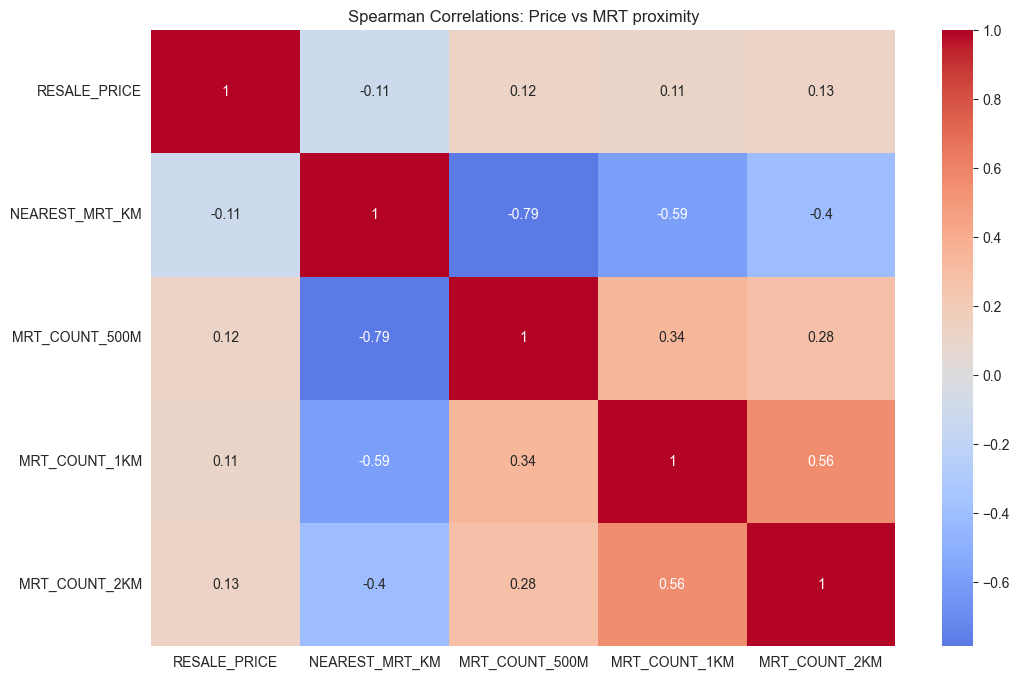

Analysis of Resale Price by Distance to Nearest MRT
    dist_bin  count    median           mean
0     ≤0.3km  16112  530000.0  570636.594923
1  0.3-0.5km  33523  518000.0  550092.897896
2    0.5-1km  76765  473000.0  505320.161920
3      1-2km  33722  480000.0  496898.071030
4      2-3km   2310  450000.0  480204.180416
5      3-5km     32  299000.0  304831.250000
6       >5km      0       NaN            NaN


<Figure size 1200x800 with 0 Axes>

In [ ]:
# Correlation heatmap and distance bin analysis

# Ensure enriched data available; if not found, compute on the fly
try:
    df_corr_source = df_out
except NameError:
    enriched_path = data_path + '/train_with_mall_features_and_hdb_coordinates_and_postal_code_with_mrt.csv'
    try:
        df_corr_source = pd.read_csv(enriched_path)
    except FileNotFoundError:
        base_df = pd.read_csv(data_path + '/train_with_mall_features_and_hdb_coordinates_and_postal_code.csv')
        stations = pd.read_csv(data_path + '/auxiliary-data/sg-mrt-stations.csv')
        stations_open = (stations.assign(STATUS=stations['STATUS'].str.lower())
                         .query("STATUS == 'open'")
                         .dropna(subset=['LATITUDE','LONGITUDE'])
                         .reset_index(drop=True))
        geo_rows = (base_df.dropna(subset=['LATITUDE','LONGITUDE'])
                             .reset_index(drop=False)
                             .rename(columns={'index':'_orig_index'}))
        feats = compute_mrt_features(geo_rows, stations_open)
        geo_rows = pd.concat([geo_rows, feats], axis=1)
        df_corr_source = base_df.copy()
        for col in ['NEAREST_MRT_KM','MRT_COUNT_500M','MRT_COUNT_1KM','MRT_COUNT_2KM']:
            df_corr_source.loc[geo_rows['_orig_index'], col] = geo_rows[col].values

cols = ['RESALE_PRICE','NEAREST_MRT_KM','MRT_COUNT_500M','MRT_COUNT_1KM','MRT_COUNT_2KM']
correlation_matrix = df_corr_source[cols].corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlations: Price vs MRT proximity')
plt.tight_layout()
plt.savefig('correlation_mrt_proximity.png', dpi=200, bbox_inches='tight')
plt.show()

# distance binning
bins = [0,0.3,0.5,1,2,3,5,10]
labels = ['≤0.3km','0.3-0.5km','0.5-1km','1-2km','2-3km','3-5km','>5km']

tmp = (df_corr_source
       .dropna(subset=['NEAREST_MRT_KM','RESALE_PRICE'])
       .assign(dist_bin=pd.cut(df_corr_source['NEAREST_MRT_KM'], bins=bins, labels=labels, include_lowest=True))
       .groupby('dist_bin', observed=False)['RESALE_PRICE']
       .agg(['count','median','mean']).reset_index())

print('Analysis of Resale Price by Distance to Nearest MRT')
print(tmp)


In [ ]:
# Load data, compute MRT features, and persist enriched dataset

df = pd.read_csv(data_path + '/train_with_mall_features_and_hdb_coordinates_and_postal_code.csv')
stations = pd.read_csv(data_path + '/auxiliary-data/sg-mrt-stations.csv')

# Keep only open stations to reflect current accessibility
stations_open = (stations.assign(STATUS=stations['STATUS'].str.lower())
                 .query("STATUS == 'open'")
                 .dropna(subset=['LATITUDE','LONGITUDE'])
                 .reset_index(drop=True))
print(f"Open MRT stations: {len(stations_open)}")

# Compute features for rows with valid coordinates
geo_rows = (df.dropna(subset=['LATITUDE','LONGITUDE'])
              .reset_index(drop=False)
              .rename(columns={'index':'_orig_index'}))

features = compute_mrt_features(geo_rows, stations_open)

# Merge back to the original dataframe
geo_rows = pd.concat([geo_rows, features], axis=1)
df_out = df.copy()
for col in ['NEAREST_MRT_KM','MRT_COUNT_500M','MRT_COUNT_1KM','MRT_COUNT_2KM']:
    df_out.loc[geo_rows['_orig_index'], col] = geo_rows[col].values

# Save
output_path = data_path + '/train_with_mall_features_and_hdb_coordinates_and_postal_code_with_mrt.csv'
df_out.to_csv(output_path, index=False)
print('Saved with MRT features ->', output_path)
print('Sample:')
print(df_out[['NEAREST_MRT_KM','MRT_COUNT_500M','MRT_COUNT_1KM','MRT_COUNT_2KM']].head())


Open MRT stations: 178
Saved with MRT features -> ../Dataset/train_with_mall_features_and_hdb_coordinates_and_postal_code_with_mrt.csv
Sample:
   NEAREST_MRT_KM  MRT_COUNT_500M  MRT_COUNT_1KM  MRT_COUNT_2KM
0        0.306039             1.0            1.0            4.0
1        1.000878             0.0            0.0            7.0
2        1.052479             0.0            0.0            3.0
3        0.872328             0.0            1.0            6.0
4        1.342852             0.0            0.0            3.0


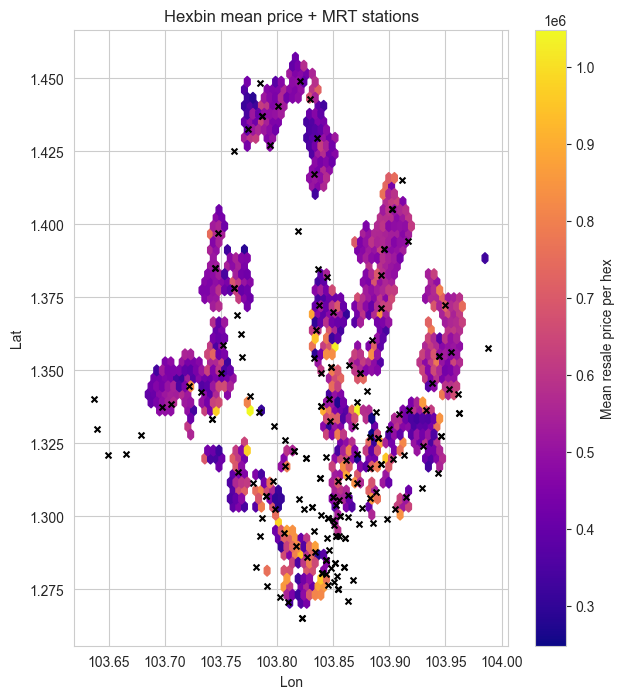

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Geographical hexbin visualization with MRT stations (robust to execution order)

# Ensure enriched data available; if not found, compute on the fly
try:
    df_geo_source = df_out
except NameError:
    enriched_path = data_path + '/train_with_mall_features_and_hdb_coordinates_and_postal_code_with_mrt.csv'
    try:
        df_geo_source = pd.read_csv(enriched_path)
    except FileNotFoundError:
        base_df = pd.read_csv(data_path + '/train_with_mall_features_and_hdb_coordinates_and_postal_code.csv')
        stations = pd.read_csv(data_path + '/auxiliary-data/sg-mrt-stations.csv')
        stations_open = (stations.assign(STATUS=stations['STATUS'].str.lower())
                         .query("STATUS == 'open'")
                         .dropna(subset=['LATITUDE','LONGITUDE'])
                         .reset_index(drop=True))
        geo_rows = (base_df.dropna(subset=['LATITUDE','LONGITUDE'])
                             .reset_index(drop=False)
                             .rename(columns={'index':'_orig_index'}))
        feats = compute_mrt_features(geo_rows, stations_open)
        geo_rows = pd.concat([geo_rows, feats], axis=1)
        df_geo_source = base_df.copy()
        for col in ['NEAREST_MRT_KM','MRT_COUNT_500M','MRT_COUNT_1KM','MRT_COUNT_2KM']:
            df_geo_source.loc[geo_rows['_orig_index'], col] = geo_rows[col].values

# Ensure open stations available
if 'stations_open' not in globals():
    stations = pd.read_csv(data_path + '/auxiliary-data/sg-mrt-stations.csv')
    stations_open = (stations.assign(STATUS=stations['STATUS'].str.lower())
                     .query("STATUS == 'open'")
                     .dropna(subset=['LATITUDE','LONGITUDE'])
                     .reset_index(drop=True))

sub = (df_geo_source.sample(min(len(df_geo_source), 30000), random_state=42)
                     .dropna(subset=['LATITUDE','LONGITUDE','RESALE_PRICE']))

plt.figure(figsize=(7,8))
hb = plt.hexbin(sub['LONGITUDE'], sub['LATITUDE'],
                C=sub['RESALE_PRICE'], gridsize=60,
                reduce_C_function=np.mean, cmap='plasma')
plt.scatter(stations_open['LONGITUDE'], stations_open['LATITUDE'], marker='x', c='k', s=18)
plt.colorbar(hb, label='Mean resale price per hex')
plt.title('Hexbin mean price + MRT stations')
plt.xlabel('Lon'); plt.ylabel('Lat')
plt.tight_layout()
plt.savefig('hexbin_mrt_stations.png', dpi=200, bbox_inches='tight')
plt.show()

